In [80]:
##############################################################################
#Libraries
import cantera as ct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import datetime
import random
import math
##############################################################################

In [90]:
#Inputs:
arduino_filepath = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\XCPC\2023-04-20.csv')
apogee_filepath = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\XCPC\4-20-2023-tilted.csv')
solsys_filepath = (r'C:\Campbellsci\DevConfig\31931_Table1_2023-04-24T08-43.dat')
#solsys_filepath = (r'C:\Campbellsci\DevConfig\31931_Table1_2023-03-09T15-28.dat')
#Flow
V_flowmeter = 1.4 #GPM
V = V_flowmeter*0.00378541/60 #Volumetric flow rate - convert GPM to m^3/s
start_time = 10 #Time in minutes when flow switched away from flowmeter
correction_factor = 1

In [91]:
##########################################################################################
#Experiment (arduino) Data
#Read file
arduino = pd.read_csv(arduino_filepath,engine='python') #Read csv

n = np.arange(50,1,1) #Manual control to remove initial setup of experiment
arduino.drop(index = n,inplace = True) #Omit first n rows

arduino.columns =['Timestamp','Unknown', 'T1', 'T2', 'T3','T4','ColdFlow','HotFlow'] #Name Columns
arduino.drop(columns=['Unknown','ColdFlow','HotFlow'],inplace = True) #Drop un-needed columns
arduino['Timestamp'] = pd.to_datetime(arduino['Timestamp'],format = '%Y-%m-%d_%H-%M-%S') #Convert time to datetime dtype
arduino['Timestamp'] = arduino['Timestamp'] - datetime.timedelta(hours=1) #FOR DAYLIGHT SAVINGS
arduino['Date'] = arduino['Timestamp'].dt.date #Get just day,month,year
arduino['Date'] = pd.to_datetime(arduino['Date']) #Make sure is datetime dtype
arduino['Time'] = pd.to_datetime(arduino['Timestamp']).dt.time #Get just hour,minute,second

arduino.drop(arduino.tail(800).index,inplace=True) #Sometimes last row is NaN when turing off so omit
arduino.reset_index(inplace=True) #Reset index to just include day/time of interest

In [92]:
##########################################################################################
#SOLAR TRACKER
#Experiment times
day = arduino['Date'][0] #What day
t_start = arduino['Time'][0] #When experiment starts
t_start.replace(second=0) 
t_end = arduino['Time'][np.size(arduino['Date'])-1] #When experiment ends
t_end.replace(second=0)

#Read File
solsys = pd.read_csv(solsys_filepath, sep=",",skiprows =[0])
solsys.drop([0,1],inplace = True) #Omit first 2 rows

#Extracting time/date
solsys['TIMESTAMP'] = pd.to_datetime(solsys['TIMESTAMP']) #Convert object to datetime
solsys['Date'] = solsys['TIMESTAMP'].dt.date #Get just day,month,year
solsys['Date'] = pd.to_datetime(solsys['Date']) #Make sure is datetime dtype
solsys['Time'] = pd.to_datetime(solsys['TIMESTAMP']).dt.time #Get just hour,minute,second

solsys = solsys.loc[solsys['Date'] == day] #Find rows of that day
solsys = solsys.loc[(solsys['Time'] >= t_start) & (solsys['Time'] <= t_end)] #Find rows of experiment time
solsys.reset_index(inplace=True) #Reset index to just include day/time of interest

In [93]:
##########################################################################################
#Tilted Apogee Pyranometer
apogee = pd.read_csv(apogee_filepath,engine='c') #Read csv

apogee.columns =['Date','Time', 'Radiation'] #Name Columns
a_time = apogee['Time']
apogee['Date'] = apogee['Date'].str.cat(a_time,sep = '-')
apogee['Date'] = pd.to_datetime(apogee['Date'],format = '%Y-%m-%d- %H:%M:%S') #Convert date string to datetime
apogee['Date'] = apogee['Date'] - datetime.timedelta(hours=1) #FOR DAYLIGHT SAVINGS
#apogee['Time'] = pd.to_datetime(apogee['Time'],format = ' %H:%M:%S').dt.time #convert time string to datetime
apogee['Time'] = apogee['Date'].dt.time
apogee.drop(apogee.tail(1).index,inplace=True) #Sometimes last value NaN when turning off, so omit

apogee = apogee.loc[(apogee['Time'] >= t_start) & (apogee['Time'] <= t_end)] #Find rows of experiment time

#apogee = apogee.loc[(apogee['Date'] >= t_start) & (apogee['Date'] <= t_end)] #Find rows of experiment time
apogee.reset_index(inplace=True) #Reset index to just include day/time of interest

In [94]:
##########################################################################################
#Arduino/apogee is per sec, solsys is per min. Find averages to put everything on 1 min basis
T2_avg = np.zeros((np.size(solsys['Date']),))
T3_avg = np.zeros((np.size(solsys['Date']),))
T4_avg = np.zeros((np.size(solsys['Date']),))
T1_avg = np.zeros((np.size(solsys['Date']),))
Rad_avg = np.zeros((np.size(solsys['Date']),))
for ii in range(0,len(solsys['Date']),1): 
    if (ii <= 2):
        T2_avg[ii] = np.average(arduino['T2'][(59*ii):(59+(ii*59))])
        T3_avg[ii] = np.average(arduino['T3'][(59*ii):(59+(ii*59))])
        T4_avg[ii] = np.average(arduino['T4'][(59*ii):(59+(ii*59))])
        T1_avg[ii] = np.average(arduino['T1'][(59*ii):(59+(ii*59))])
        Rad_avg[ii] = np.average(apogee['Radiation'][(59*ii):(59+(ii*59))])
    elif (ii >=10):
        T2_avg[ii] = np.average(arduino['T2'][((ii*59)-59):((ii*59))])
        T3_avg[ii] = np.average(arduino['T3'][((59*ii)-59):((ii*59))])
        T4_avg[ii] = np.average(arduino['T4'][((59*ii)-59):((ii*59))])
        T1_avg[ii] = np.average(arduino['T1'][((59*ii)-59):((ii*59))])
        Rad_avg[ii-2] = np.average(apogee['Radiation'][((59*ii)-59):(ii*59)])
    else:
        T2_avg[ii] = np.average(arduino['T2'][((ii*59)-59):((ii*59))])
        T3_avg[ii] = np.average(arduino['T3'][((59*ii)-59):((ii*59))])
        T4_avg[ii] = np.average(arduino['T4'][((59*ii)-59):((ii*59))])
        T1_avg[ii] = np.average(arduino['T1'][((59*ii)-59):((ii*59))])
        Rad_avg[ii-2] = np.average(apogee['Radiation'][((59*ii)-59):(ii*59)])
solsys['T2'] = T2_avg
solsys['T3'] = T3_avg
solsys['T1'] = T1_avg
solsys['T4'] = T4_avg
solsys['Tilt'] = Rad_avg


solsys.reset_index(inplace=True)


In [95]:
##########################################################################################
#HEAT INPUT

#Properties of Water
fluid = ct.Water()
h_2 = np.zeros((np.size(solsys['Date']),))
h_3 = np.zeros((np.size(solsys['Date']),))
rho = np.zeros((np.size(solsys['Date']),))
for jj in range(0,len(solsys['Date']),1):
    fluid.TQ = solsys['T2'][jj]+273.16,0
    h_2[jj] = fluid.HP[0] 
    rho[jj] = fluid.TD[1]
    fluid.TQ = abs(solsys['T3'][jj])+273.16,0
    h_3[jj] = fluid.HP[0] 
    
V_dot = np.zeros((np.size(solsys['Date']),))
V_dot[0:start_time] =  V*np.ones(start_time)
V_dot[start_time:]  =  correction_factor*V*np.ones((np.size(solsys['Date']))-start_time)

#For old date
#_dot[0:start_time] =  V*np.ones(start_time)
#V_dot[start_time:]  =  1.3*V*np.ones((np.size(solsys['Date']))-start_time)
#V_dot[start_time:96]  =  1.3*V*np.ones(96-start_time)
#V_dot[96:]  =  (2.4)*V*np.ones((np.size(solsys['Date']))-96)

#HEAT INPUT TO FLOW
Qheat = np.zeros((np.size(solsys['Date']),))
Qheat = V_dot*rho[1]*(h_2 - h_3) #Heat input

#No cantera method
cp = 4.18*1000
rho = 997
#HEAT INPUT TO FLOW
#Qheat = V*(solsys['T2']*rho*cp - solsys['T3']*rho*cp) #Heat input

In [96]:
##########################################################################################
#Radiation
def B(n):
    return (n-1)*360/365*np.pi/180
#Time correction Equation
def E(n):
    return 229.2*(0.000075+0.001868*np.cos(B(n))-0.032077*np.sin(B(n))-0.014615*np.cos(2*B(n))-0.04089*np.sin(2*B(n)))
#Declintion Angle
def delta(n):
    return 23.45*np.sin(360*(284+n)/365*np.pi/180)
#Rb - to relate normal beam radiation to tilted
def rb(lat,beta,declination,hour):
    return (np.cos((lat-beta)*np.pi/180)*np.cos(declination*np.pi/180)*np.cos(hour*np.pi/180) \
         +  np.sin((lat-beta)*np.pi/180)*np.sin(declination*np.pi/180)) / (np.cos(lat*np.pi/180)*np.cos(declination*np.pi/180)*\
            np.cos(hour*np.pi/180)+np.sin(lat*np.pi/180)*np.sin(declination*np.pi/180))
#Angle of Incidence
def theta(n,lat,beta,azimuth,hour): 
    return np.arccos(np.sin(delta(n)*np.pi/180)*np.sin(lat*np.pi/180)*np.cos(beta*np.pi/180)- \
                     np.sin(delta(n)*np.pi/180)*np.cos(lat*np.pi/180)*np.sin(beta*np.pi/180)*np.cos(azimuth*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.cos(lat*np.pi/180)*np.cos(beta*np.pi/180)*np.cos(hour*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.sin(lat*np.pi/180)*np.sin(beta*np.pi/180)*np.cos(azimuth*np.pi/180)*np.cos(hour*np.pi/180)+ \
                     np.cos(delta(n)*np.pi/180)*np.sin(beta*np.pi/180)*np.sin(azimuth*np.pi/180)*np.sin(hour*np.pi/180))
n = day.dayofyear #Day number out of 365
declination = delta(day.dayofyear)
beta = 28 #tilt of XCPC
lat  = 29.6516 #Latitude of gainesville
long = 82.3248 #longitude of gainesville
Lst  = 75 #GMT-5
solar_t = np.zeros((np.size(solsys['Date']),)) #Initialize solar time
hour =  np.zeros((np.size(solsys['Date']),)) #Initialize hour angle
for jj in range(0,len(solsys['Date']),1):
    solar_t[jj] =  solsys['Time'][jj].hour + solsys['Time'][jj].minute/60  + 4*(Lst - long)/60 + E(day.dayofyear)/60 #SolarTime
    hour[jj] = (solar_t[jj]-12)*15 #Hour angle

Gtot_model = (solsys['CMP10_GHI_Avg'].astype(float)-solsys['CMP10_DHI_Avg'].astype(float))*rb(lat,beta,declination,hour) \
             + (1+np.cos(beta*np.pi/180))/2 * solsys['CMP10_DHI_Avg'].astype(float) 
incidence  = theta(n,lat,beta,0,hour) * 180/np.pi

#Efficiency
A = 2.4 #Area of collector, m^2
eta = Qheat/(A*solsys['Tilt'])

#Storing in Dataframe
solsys['Efficiency'] = eta
solsys['Incidence Angle'] = incidence
solsys['Flow'] = V_dot/(0.00378541/60)

In [97]:
#Uncertainty Analysis
U_T = 0.022
U_V = 0.05
U_G = 0.05
dndT = (V*rho*cp)/(A*solsys['Tilt'])
dndV = rho*cp*(solsys['T2'] - solsys['T3'])/(A*solsys['Tilt'])
dndG = V*rho*cp*(solsys['T2'] - solsys['T3'])/(A*(solsys['Tilt'])**2)
U_eta = ( (dndT*U_T*solsys['T2'])**2 + (dndT*U_T*solsys['T3'])**2 + (dndV*U_V*V)**2 + + (dndG*U_G*solsys['Tilt'])**2 )**(1/2)

D_eta_positive = eta + U_eta*eta
D_eta_negative = eta - U_eta*eta
#U_eta = ( (U_T)**2 + (U_T)**2 + (U_V)**2 + + (U_G)**2 )**(1/2)

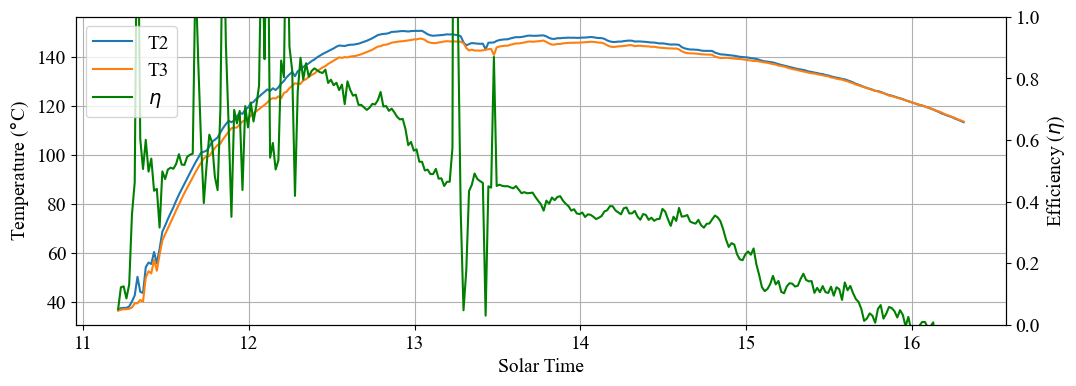

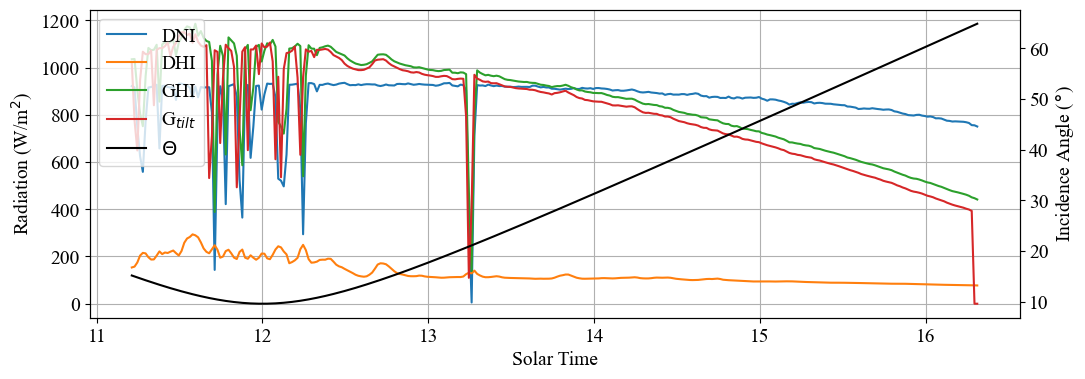

In [98]:
# PLOTS
##########################################################################################
#Plot Temperature
pfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

#ax1.plot(solsys['TIMESTAMP'],solsys['T2'].astype(float), label = 'T2')
#ax1.plot(solsys['TIMESTAMP'],solsys['T3'].astype(float), label = 'T3')
#ax2.plot(solsys['TIMESTAMP'],eta,'g',label='$\eta$')

ax1.plot(solar_t,solsys['T2'].astype(float), label = 'T2')
ax1.plot(solar_t,solsys['T3'].astype(float), label = 'T3')
ax2.plot(solar_t,eta,'g',label='$\eta$')

#ax2.plot(solsys['TIMESTAMP'],D_eta_negative,'#15B01A',linestyle=':')
#ax2.plot(solsys['TIMESTAMP'],D_eta_positive,'#15B01A',linestyle=':')

ax1.set_xlabel("Solar Time")
ax1.set_ylabel("Temperature ($\degree$C)")      
ax2.set_ylabel('Efficiency ($\eta$)', color='k')
 
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.size'] = 14
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
ax1.grid()   
plt.ylim(0,1)
xformatter = mdates.DateFormatter('%H:%M')
#plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.show()
##########################################################################################
#Plot Radiation
pfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

#ax1.plot(solsys['TIMESTAMP'],solsys['CHP1_DNI_Avg'].astype(float), label='DNI')   
#ax1.plot(solsys['TIMESTAMP'],solsys['CMP10_DHI_Avg'].astype(float), label='DHI')
#ax1.plot(solsys['TIMESTAMP'],solsys['CMP10_GHI_Avg'].astype(float), label='GHI')  
#ax1.plot(solsys['TIMESTAMP'],solsys['Tilt'], label='G$_{tilt}$')
#ax2.plot(solsys['TIMESTAMP'],solsys['Incidence Angle'],'k',label='$\Theta$')

ax1.plot(solar_t,solsys['CHP1_DNI_Avg'].astype(float), label='DNI')   
ax1.plot(solar_t,solsys['CMP10_DHI_Avg'].astype(float), label='DHI')
ax1.plot(solar_t,solsys['CMP10_GHI_Avg'].astype(float), label='GHI')  
ax1.plot(solar_t,solsys['Tilt'], label='G$_{tilt}$')
#ax1.plot(solar_t,Gtot_model, label='Modeled G$_{tilt}$')
ax2.plot(solar_t,solsys['Incidence Angle'],'k',label='$\Theta$')

ax1.set_xlabel("Solar Time")
ax1.set_ylabel("Radiation (W/m$^{2}$)")     
ax2.set_ylabel('Incidence Angle ($\degree$)', color='k')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.size'] = 14
font = matplotlib.font_manager.FontProperties(family='Times New Roman',style='normal', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
ax1.grid()   
xformatter = mdates.DateFormatter('%H:%M')
#plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.show()
##########################################################################################

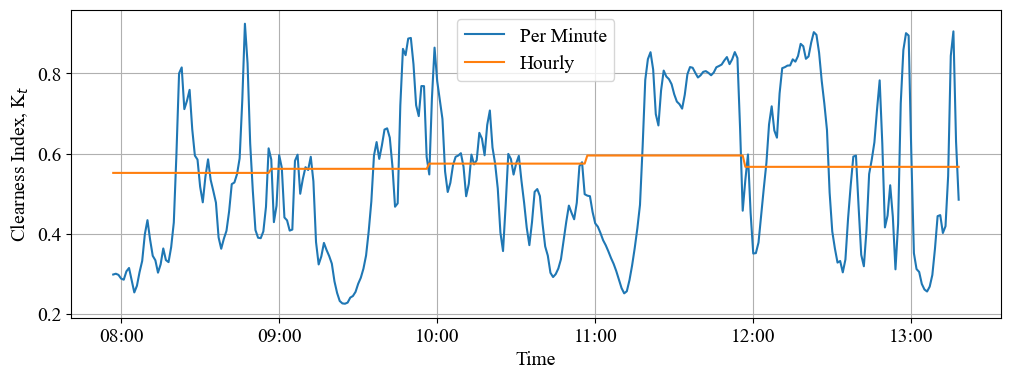

In [52]:
##########################################################################################
#Clearness Index Calculation

Gsc = 1367 #W m-2 
def Gon(n): 
    return Gsc*(1+0.033*np.cos(360*n/365*np.pi/180))  
#Daily 
def H_o(n,sunset_angle,lat,delta):
    return (Gon(n)*24*3600/np.pi)*( (np.cos(lat*np.pi/180)*np.cos(delta*np.pi/180)*np.sin(sunset_angle*np.pi/180))\
                                  +(np.sin(lat*np.pi/180)*np.sin(delta*np.pi/180)*sunset_angle*np.pi/180))
#Hourly 
def I_o(n,w1,w2,lat,delta):
    return (Gon(n)*12*3600/np.pi)*( (np.cos(lat*np.pi/180)*np.cos(delta*np.pi/180)*(np.sin(w2*np.pi/180)-np.sin(w1*np.pi/180)))\
                                  +(np.sin(lat*np.pi/180)*np.sin(delta*np.pi/180)*(w2-w1)*np.pi/180))
#Sunset Hour Angle
def sunset(lat,n):
    return np.arccos(-np.tan(lat*np.pi/180)*np.tan(delta(n)*np.pi/180))*180/np.pi

#HOURLY
#kt_h = np.zeros(math.ceil(len(solsys['Date'])/60))
kt_h = np.zeros(len(solsys['Date']))
for ii in range(0,math.ceil(len(solsys['Date'])/60)-1,1):
    if (ii - math.ceil(len(solsys['Date'])/60)) > 0:
        w1 = (solar_t[ii*60]-12)*15 #Convert to hour angle bounds of interest
        w2 = (solar_t[(ii+1)*60]-12)*15
        Io = I_o(n,w1,w2,lat,declination) 
        I = np.trapz(solsys['CMP10_GHI_Avg'][ii*60:(ii+1)*60].astype(float),dx=60) #Numerically integrate GHI data
        kt_h[ii*60:(ii+1)*60] = I/Io
    else:
        w1 = (solar_t[ii*60]-12)*15 #Convert to hour angle bounds of interest
        w2 = (solar_t[len(solar_t)-1]-12)*15
        Io = I_o(n,w1,w2,lat,declination) 
        I = np.trapz(solsys['CMP10_GHI_Avg'][ii*60:len(solar_t)-1].astype(float),dx=60) #Numerically integrate GHI data
        kt_h[ii*60:len(solar_t)-1] = I/Io
    
#Per Time stamp
kt =  np.zeros(len(solsys['Date']))
for ii in range(0,len(solsys['Date'])-1,1):
    w1 = (solar_t[ii]-12)*15   #Convert to hour angle bounds of interest
    w2 = (solar_t[(ii+1)]-12)*15
    Io = I_o(n,w1,w2,lat,declination) 
    I  = np.trapz(solsys['CMP10_GHI_Avg'][ii:(ii+2)].astype(float),dx=60) #Numerically integrate GHI data
    kt[ii] = I/Io
solsys['Clearness'] = kt
       
#Plot
pfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(solsys['TIMESTAMP'][0:len(solar_t)-2],kt[0:len(solar_t)-2],label = 'Per Minute')
plt.plot(solsys['TIMESTAMP'][0:len(solar_t)-2],kt_h[0:len(solar_t)-2],label = 'Hourly')
plt.xlabel('Time')
plt.ylabel('Clearness Index, K$_{t}$')
plt.legend()
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.grid()
plt.show()


In [23]:
##########################################################################################
#Save Consolidated Dataframe as excel/csv
#n = np.arange(159,224,1) #Manual control to remove initial setup of experiment
#solsys.drop(index = n,inplace = True) #Omit first n rows
solsys.drop(columns=['level_0','index','TIMESTAMP','BattV_Avg', 'PTemp_C_Avg'],inplace = True)#Drop un-needed columns
solsys = solsys.loc[:,['Date', 'Time','CMP10_GHI_Avg', 'CMP10_DHI_Avg', 'CHP1_DNI_Avg','Tilt','T2', 'T3', 'T1', 'T4','Flow', 'Efficiency',\
       'Clearness','Incidence Angle','ZenDeg', 'AzDeg']]
save_filepath = (r'C:\Users\Woodrow\Desktop\Work_w_Scheffe\Consolidated_XCPC\2023-04-11_Total.csv')
#solsys.to_csv(save_filepath)

In [126]:
np.min(solsys['Incidence Angle'])

6.263970060377727

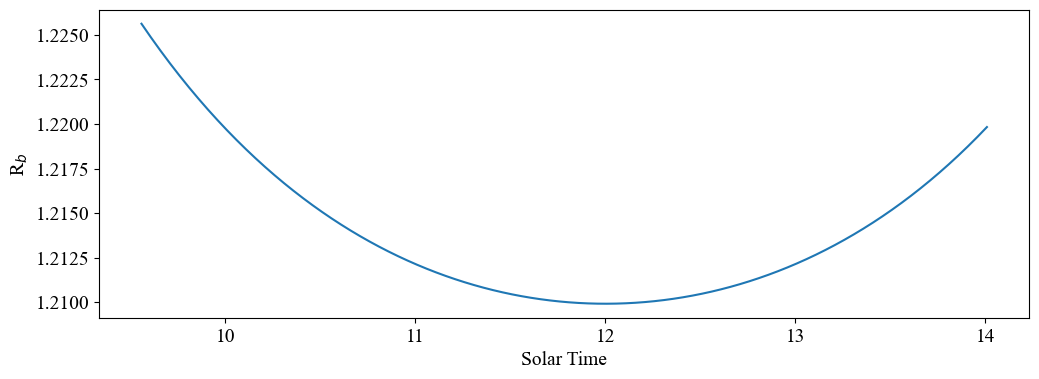

In [62]:
y = rb(lat,beta,declination,hour)
plt.plot(solar_t,y)
plt.ylabel('R$_{b}$')
plt.xlabel('Solar Time')
plt.show()

In [15]:
import scipy
scipy.integrate.trapz(solsys['Tilt'],dx=1)*60/10000

758.1472881355932

In [31]:
V

9.463525e-05

In [32]:
V*2

0.0001892705

In [33]:
V/2

4.7317625e-05